# Implémentation des bibliothèques

In [147]:
#!pip install import-ipynb


In [148]:
import pandas as pd  # Manipulation de données
import numpy as np  # Calculs numériques
import matplotlib.pyplot as plt  # Visualisation de données
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor
import seaborn as sns  # Visualisation avancée
import sklearn
import random
from datetime import datetime
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
# Importation des bibliothèques de scikit-learn pour la modélisation
from sklearn.model_selection import train_test_split  # Division des données en ensembles d'entraînement et de test
from sklearn.ensemble import RandomForestClassifier  # Modèle de classification Random Forest
from sklearn.linear_model import LinearRegression  # Modèle de régression linéaire
from sklearn.pipeline import make_pipeline  # Construction de pipelines pour le prétraitement et les modèles
from sklearn.preprocessing import StandardScaler, PolynomialFeatures  # Normalisation et transformation polynomiale
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer  # Imputation des valeurs manquantes
from sklearn.decomposition import PCA  # Réduction de dimension avec PCA
from sklearn.metrics import accuracy_score, classification_report   # Évaluation des modèles
from sklearn.metrics import confusion_matrix

# Import des outils de scikit-learn nécessaires
from sklearn.model_selection import GridSearchCV  # Optimisation des hyperparamètres
from sklearn.metrics import roc_auc_score, roc_curve  # Évaluation avec AUC-ROC
from sklearn.model_selection import cross_val_score  # Validation croisée
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import label_binarize


Un **Random Forest Classifier** repose su les principes suivants en partant de ** notre base de données** :
- **Bagging (Bootstrap Aggregation)** : Échantillonnage aléatoire avec remplacement.  
- **Arbres de décision (Decision Trees)** : Classificateurs individuels. (Random Subspace Method)
- **Sélection aléatoire des features** : Chaque arbre utilise un sous-ensemble des caractéristiques.  

# Importation des données

In [149]:
# Charger le fichier Excel
# df = pd.read_excel("C:\\Users\\anton\\Downloads\\sncf_data.xlsx")  
df = pd.read_excel("C:\\Users\\\scoup\\Downloads\\sncf_data.xlsx")
# Convertir en CSV
df.to_csv("data_csv", index=False, encoding="utf-8")
# On ne prend pas en compte les colonnes "qté cible" et "product policy" (trop de valeurs manquantes)*
df = df.drop(columns=['qté cible','product policy (short-term vision year - 2023)'])
df.fillna(0, inplace=True)  # Remplace les NaN par 0

# Convertir les colonnes de dates en nombre de jours depuis aujourd'hui
for col in df.select_dtypes(include=['datetime64']):
    df[col] = (datetime.today() - df[col]).dt.days 
    
# Séparer les features (X) et la cible (y)
target_column = "label"  # Remplace par le nom de ta colonne cible
X = df.drop(columns=[target_column])
y = df[target_column]

X

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\scoup\AppData\Local\Temp\ipykernel_11708\933080086.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_excel("C:\\Users\\\scoup\\Downloads\\sncf_data.xlsx")


,symbol,supplier,serial letter,repair complexity (0NA),evaluation ratio between repair cost and cost of new (0NA),\nexisting substitute product (0NA),component having a role in security (0NA),does the product/block if the component have a role in security? (0NA),several components involved? (0NA),is the product recent? (<10 years) (0NA),\nis the cost of inventory expensive (0NA),substitution component not available (0NA),do we have equipment to carry out approval tests? (0NA),have we done a technical validation? (0NA),generally at least equivalent criterion,active quantity,quantity of existing stock at SNCF?,"no longer supply (new or used), no longer supply new, reparable, supply new",processing date
0,79544181,SCLE,AB,1,1,1,1,1,1,0,0.0,0,0,0,1,1050,837,supply new,607
1,79402561,SCLE,BA,0,0,0,0,0,1,0,0.0,1,1,1,1,436,999,supply new,601
2,79540265,SCLE,BA,0,0,1,0,1,0,0,0.0,0,1,1,1,70,1655,supply new,945
3,79540265,SCLE,BB,0,0,1,0,1,0,0,0.0,0,1,1,1,149,1655,supply new,945
4,79540265,SCLE,BBM,0,0,1,0,1,0,0,0.0,0,1,1,1,24,1655,supply new,945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,79545633,HITACHI,B__,1,0,0,1,1,1,0,0.0,1,1,1,0,0,876,supply new,2194
313,79545464,Alstom,AAA,0,0,0,1,0,0,0,0.0,0,1,1,1,6844,2305,supply new,5540
314,79545106,Alstom,AE,0,0,0,1,1,1,0,0.0,0,1,1,1,30,3583,supply new,896
315,79545106,Alstom,AE,0,0,0,1,1,1,0,0.0,0,1,1,1,30,3583,supply new,896


In [150]:
# Stocker la colonne "symbol" pour l'afficher plus tard
X["symbol"] = df["symbol"]
categorical_features = X.nunique()[X.nunique() == 2].index.tolist()
# Encodage des variables catégorielles si nécessaire
X = pd.get_dummies(X)
# je crois il faut pas supprimer la première colonne
# X = pd.get_dummies(X)

X["\nis the cost of inventory expensive (0NA)"]=X["\nis the cost of inventory expensive (0NA)"].astype(int)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Columns: 114 entries, symbol to no longer supply (new or used), no longer supply new, reparable, supply new_supply new
dtypes: bool(98), int64(16)
memory usage: 70.1 KB


# Fonction test_train_split

In [151]:
def custom_train_test_split_df(X, y, test_size, random_state, stratify=None):
    np.random.seed(random_state)
    # Vérifie si `X` est un DataFrame pour conserver les noms des colonnes.
    if isinstance(X, pd.DataFrame):
        columns = X.columns  # Sauvegarder les noms des colonnes
    else:
        columns = None  # Gérer les cas où X n'est pas un DataFrame
    
    X = np.array(X)
    y = np.array(y)
    
    if stratify is not None:
        # Séparation stratifiée
        unique_classes, class_counts = np.unique(y, return_counts=True)
        X_train, X_test, y_train, y_test = [], [], [], []
        
        for class_label, count in zip(unique_classes, class_counts):
            # Sélectionner les indices des échantillons de la classe actuelle
            indices = np.where(y == class_label)[0]
            np.random.shuffle(indices)
            test_count = int(count * test_size)
            test_indices = indices[:test_count]
            train_indices = indices[test_count:]
            # Ajouter les échantillons aux ensembles d'entraînement et de test
            X_train.extend(X[train_indices])
            X_test.extend(X[test_indices])
            y_train.extend(y[train_indices])
            y_test.extend(y[test_indices])
        
        X_train, X_test = np.array(X_train), np.array(X_test)
        y_train, y_test = np.array(y_train), np.array(y_test)
    
    else:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        test_count = int(len(X) * test_size)
        test_indices = indices[:test_count]
        train_indices = indices[test_count:]
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
    
    if columns is not None:
        df_train = pd.DataFrame(X_train, columns=columns)
        df_test = pd.DataFrame(X_test, columns=columns)
    else:
        df_train = pd.DataFrame(X_train)
        df_test = pd.DataFrame(X_test)
    # Ajouter la colonne cible au train et test
    df_train['label'] = y_train
    df_test['label'] = y_test
    
    return df_train, df_test

In [152]:
df_train,df_test = custom_train_test_split_df(X, y, test_size=0.2,random_state=42,stratify=y)
len(df_train)
df_train.info()
df_train.head()

df_train.columns = df_train.columns.str.replace(' ', '').str.replace('\n', '')
df_test.columns = df_test.columns.str.replace(' ', '').str.replace('\n', '')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Columns: 115 entries, symbol to label
dtypes: object(115)
memory usage: 230.1+ KB


In [153]:
df_train.columns 
df_test.iloc[:50]

,symbol,repaircomplexity(0NA),evaluationratiobetweenrepaircostandcostofnew(0NA),existingsubstituteproduct(0NA),componenthavingaroleinsecurity(0NA),doestheproduct/blockifthecomponenthavearoleinsecurity?(0NA),severalcomponentsinvolved?(0NA),istheproductrecent?(<10years)(0NA),isthecostofinventoryexpensive(0NA),substitutioncomponentnotavailable(0NA),...,serialletter_EBH,serialletter_EC,serialletter_ECF,serialletter_FA,serialletter_FB,serialletter____,"nolongersupply(neworused),nolongersupplynew,reparable,supplynew_nolongersupplynew","nolongersupply(neworused),nolongersupplynew,reparable,supplynew_reparable","nolongersupply(neworused),nolongersupplynew,reparable,supplynew_supplynew",label
0,79545473,0,0,1,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,LBO
1,79545018,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,LBO
2,79545019,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,LBO
3,79545018,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,LBO
4,79545016,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,LBO
5,79545017,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,LBO
6,79544359,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,redesign majeur
7,79544009,0,0,0,1,1,0,1,0,1,...,True,False,False,False,False,False,False,True,False,redesign majeur
8,79544360,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,redesign majeur
9,79544360,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,redesign majeur


# Boostrapping

In [154]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    return df_bootstrapped

In [155]:
df_boostrapping = bootstrapping(df_train, 10)
df_boostrapping

,symbol,repaircomplexity(0NA),evaluationratiobetweenrepaircostandcostofnew(0NA),existingsubstituteproduct(0NA),componenthavingaroleinsecurity(0NA),doestheproduct/blockifthecomponenthavearoleinsecurity?(0NA),severalcomponentsinvolved?(0NA),istheproductrecent?(<10years)(0NA),isthecostofinventoryexpensive(0NA),substitutioncomponentnotavailable(0NA),...,serialletter_EBH,serialletter_EC,serialletter_ECF,serialletter_FA,serialletter_FB,serialletter____,"nolongersupply(neworused),nolongersupplynew,reparable,supplynew_nolongersupplynew","nolongersupply(neworused),nolongersupplynew,reparable,supplynew_reparable","nolongersupply(neworused),nolongersupplynew,reparable,supplynew_supplynew",label
20,79545017,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,LBO
47,79544362,0,0,0,1,1,0,1,0,1,...,False,False,False,False,False,False,False,False,True,redesign majeur
147,79520902,0,1,1,1,1,0,1,0,0,...,False,False,False,False,False,True,False,False,True,stock
247,79520904,0,0,0,0,1,1,0,0,0,...,False,False,False,False,False,False,False,True,False,substitution
127,79520541,0,0,0,1,1,1,0,0,1,...,False,False,False,False,False,False,False,True,False,redesign mineur
135,79520541,0,0,0,1,1,1,0,0,1,...,False,False,False,False,False,False,False,True,False,redesign mineur
134,79520541,0,0,0,1,1,1,0,0,1,...,False,False,False,False,False,False,False,True,False,redesign mineur
194,79565032,0,0,0,0,1,0,1,0,0,...,False,False,False,False,False,False,False,True,False,substitution
144,79520541,0,0,0,1,1,1,0,0,1,...,False,False,False,False,False,False,False,True,False,redesign mineur
127,79520541,0,0,0,1,1,1,0,0,1,...,False,False,False,False,False,False,False,True,False,redesign mineur


# Fonction permettant de distinguer les variables binaires(1/0 ou Vrai/Faux) et les variables continue (active quantity,quantity existing,processing date)

In [156]:
def determine_type_of_feature(df):
    
    feature_types = []
    # On considère qu'une variable catégorielle a moins de 2 valeurs uniques vu qu'on a fait un encodage one-hot
    n_unique_values_treshold = 2
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [157]:
determine_type_of_feature(df_train)

['continuous',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'continuous',
 'continuous',
 'continuous',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorical',
 'categorica

# Fonction d'arbre de decision 

## Purete d'une feuille

In [158]:
# Une feuille est-elle pure 
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)
    # il y a qu'une seule classe
    if len(unique_classes) == 1:
        return True
    else:
        return False

In [159]:
# Création d'exemples de jeux de données pour tester la fonction check_purity()

# Jeu de données où toutes les étiquettes sont identiques (pures)
data_pure = np.array([
    [5.1, 3.5, 1.4, 0.2, "Setosa"],
    [4.9, 3.0, 1.4, 0.2, "Setosa"],
    [4.7, 3.2, 1.3, 0.2, "Setosa"],
    [4.6, 3.1, 1.5, 0.2, "Setosa"]
])

# Jeu de données contenant différentes classes (mélangées)
data_mixed = np.array([
    [5.1, 3.5, 1.4, 0.2, "Setosa"],
    [7.0, 3.2, 4.7, 1.4, "Versicolor"],
    [6.3, 3.3, 6.0, 2.5, "Virginica"],
    [4.9, 3.0, 1.4, 0.2, "Setosa"]
])


# Test de la fonction
pure_test = check_purity(data_pure)  # Doit retourner True
mixed_test = check_purity(data_mixed)  # Doit retourner False

pure_test, mixed_test

(True, False)

## Determine la classe majoritaire

In [160]:
def class_majoritaire(data):
    label_column = data[:, -1]
    unique_classes, count_unique_classes = np.unique(label_column, return_counts=True)
    # on prend la classe majoritaire
    index = count_unique_classes.argmax()
    class_majoritaire = unique_classes[index]
    return class_majoritaire

In [161]:
# Création d'exemples de jeux de données pour tester la fonction class_majoritaire()

# Jeu de données avec une classe majoritaire évidente
data_majority_A = np.array([
    [5.1, 3.5, 1.4, 0.2, "A"],
    [4.9, 3.0, 1.4, 0.2, "A"],
    [4.7, 3.2, 1.3, 0.2, "B"],
    [4.6, 3.1, 1.5, 0.2, "A"],
    [5.0, 3.4, 1.6, 0.4, "A"],
    [5.2, 3.5, 1.5, 0.2, "B"]
])

# Jeu de données avec une autre classe majoritaire
data_majority_B = np.array([
    [6.1, 2.8, 4.7, 1.2, "B"],
    [5.7, 2.5, 5.0, 2.0, "B"],
    [6.0, 2.9, 4.5, 1.5, "A"],
    [6.3, 3.3, 6.0, 2.5, "B"],
    [6.4, 2.8, 5.6, 2.1, "B"],
    [6.2, 2.8, 4.8, 1.8, "A"]
])


# Test de la fonction
majority_A = class_majoritaire(data_majority_A)  # Doit retourner "A"
majority_B = class_majoritaire(data_majority_B)  # Doit retourner "B"

majority_A, majority_B

(np.str_('A'), np.str_('B'))

In [162]:
# Quelles sont les séparartions possible dans l'arbre? 
def get_potential_splits(data):
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):  # excluding the last column which is the label
        # on prend toutes les valeurs de chaque colonne
        values = data[:, column_index]
        # on prend les valeurs uniques des valeurs
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [163]:
# Création d'un exemple de jeu de données pour tester get_potential_splits()

data_example = np.array([
    [5.1, 3.5, 1.4, "A"],
    [4.9, 3.0, 1.4, "B"],
    [4.7, 3.2, 1.3, "A"],
    [4.6, 3.1, 1.5, "B"],
    [5.0, 3.4, 1.6, "A"]
])


# Test de la fonction
potential_splits_example = get_potential_splits(data_example)
potential_splits_example


{0: array(['4.6', '4.7', '4.9', '5.0', '5.1'], dtype='<U32'),
 1: array(['3.0', '3.1', '3.2', '3.4', '3.5'], dtype='<U32'),
 2: array(['1.3', '1.4', '1.5', '1.6'], dtype='<U32')}

In [164]:
# 1.4 Calcul de l'impurete de gini
def calculate_gini(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    # probabilité de chaque classe
    probabilities = counts / counts.sum()
    # gini
    gini = 1 - sum(probabilities ** 2)
    
    return gini

In [165]:
# Exemple
data = np.array([
    [1, 'A'],
    [2, 'A'],
    [3, 'B'],
    [4, 'B'],
    [5, 'B']
])

gini_impurity = calculate_gini(data)
print("Gini Impurity:", gini_impurity)

Gini Impurity: 0.48


In [166]:
# calcul de l'impurete gini pour un split
def calculate_overall_gini(data_below, data_above):
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n
    
    overall_gini = (p_data_below * calculate_gini(data_below) 
                    + p_data_above * calculate_gini(data_above))
    
    return overall_gini

In [167]:
# Example data
data = np.array([
    [1, 'A'],
    [2, 'A'],
    [3, 'B'],
    [4, 'B'],
    [5, 'B']
],dtype=object)

# Split the data
data[:, 0]=data[:,0].astype(int)
data_below = data[data[:, 0] <= 3]
data_above = data[data[:, 0] > 3]

# Calculate overall Gini impurity
overall_gini = calculate_overall_gini(data_below, data_above)
print("Overall Gini Impurity:", overall_gini)

Overall Gini Impurity: 0.26666666666666666


## Faire les separations pour diminuer l'impurete de gini

In [168]:
# Split data
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]
    
    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # Feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [169]:
# Création d'un exemple de jeu de données pour tester split_data()

# Définition des types de features
FEATURE_TYPES = ["continuous", "continuous", "categorical"]  # Les deux premières colonnes sont continues, la troisième est catégorielle

# Données factices avec des variables continues et catégorielles
data_example = np.array([
    [5.1, 3.5, "A"],
    [4.9, 3.0, "B"],
    [4.7, 3.2, "A"],
    [4.6, 3.1, "B"],
    [5.0, 3.4, "A"]
], dtype=object)  # Utilisation de dtype=object pour mélanger nombres et chaînes

# Test de la fonction avec une variable continue (colonne 0, valeur de split = 4.8)
data_below_cont, data_above_cont = split_data(data_example, split_column=0, split_value=4.8)

# Test de la fonction avec une variable catégorielle (colonne 2, valeur de split = "A")
data_below_cat, data_above_cat = split_data(data_example, split_column=2, split_value="A")

data_below_cont, data_above_cont



(array([[4.7, 3.2, 'A'],
        [4.6, 3.1, 'B']], dtype=object),
 array([[5.1, 3.5, 'A'],
        [4.9, 3.0, 'B'],
        [5.0, 3.4, 'A']], dtype=object))

In [170]:
data_below_cat, data_above_cat

(array([[5.1, 3.5, 'A'],
        [4.7, 3.2, 'A'],
        [5.0, 3.4, 'A']], dtype=object),
 array([[4.9, 3.0, 'B'],
        [4.6, 3.1, 'B']], dtype=object))

In [171]:
# Détermination du meilleur split en utilisant l'impureté de Gini
def determine_best_split(data, potential_splits):
    overall_gini = 9999  # Initialiser avec une valeur élevée
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_gini = calculate_overall_gini(data_below, data_above)
            
            if current_overall_gini <= overall_gini:
                overall_gini = current_overall_gini
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


In [172]:
# Test de la fonction determine_best_split()
potential_splits = get_potential_splits(data_example)
best_column, best_value = determine_best_split(data_example, potential_splits)

best_column, best_value

(1, 3.1)

# Algorithme de construction de l'arbre de décision

In [173]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):
    
    # Préparation des données
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    # Cas d'arrêt 
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = class_majoritaire(data)
        return classification

    # Sélection des features aléatoires pour Random Forest
    if random_subspace:
        feature_indices = np.random.choice(len(COLUMN_HEADERS) - 1, size=random_subspace, replace=False)
    else:
        feature_indices = range(len(COLUMN_HEADERS) - 1)  # Utiliser toutes les features sauf la cible

    # Incrémentation de la profondeur
    counter += 1

    # Sélection des meilleurs splits en fonction des features sélectionnées
    potential_splits = get_potential_splits(data)
    potential_splits = {k: v for k, v in potential_splits.items() if k in feature_indices}
    
    split_column, split_value = determine_best_split(data, potential_splits)
    data_below, data_above = split_data(data, split_column, split_value)
    
    # Vérifier si l'un des groupes est vide
    if len(data_below) == 0 or len(data_above) == 0:
        classification = class_majoritaire(data)
        return classification
    
    # Construire la question
    feature_name = COLUMN_HEADERS[split_column]
    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        question = "{} <= {}".format(feature_name, split_value)
    else:
        question = "{} = {}".format(feature_name, split_value)
    
    # Initialiser le sous-arbre
    sub_tree = {question: []}
    
    # Récursion pour construire les sous-arbres
    yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
    no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
    
    # Optimisation : Si les deux réponses sont identiques, on ne garde pas la question
    if yes_answer == no_answer:
        sub_tree = yes_answer
    else:
        sub_tree[question].append(yes_answer)
        sub_tree[question].append(no_answer)
    
    return sub_tree


In [174]:
# Exécution de l'algorithme avec le dataset factice
tree = decision_tree_algorithm(df_boostrapping, min_samples=2, max_depth=150)
question = list(tree.keys())[0]
tree

{'processingdate <= 692': ['redesign mineur',
  {'nolongersupply(neworused),nolongersupplynew,reparable,supplynew_supplynew = True': [{'serialletter____ = True': ['stock',
      {'serialletter_AE = True': ['redesign majeur', 'LBO']}]},
    'substitution']}]}

## Faire une prédiction

In [175]:
def parse_question(question):
    """Sépare une condition sous forme de texte en feature, opérateur et valeur."""
    parts = question.split(" ", 2)
    if len(parts) == 3:
        feature_name, comparison_operator, value = parts
    else:
        raise ValueError(f"Format incorrect pour la question: {question}")
    return feature_name.strip(), comparison_operator.strip(), value.strip()
feature_name, comparison_operator, value = parse_question(list(tree.keys())[0])
type(value)


str

Vérifier si la clé est un label final
    if question in ["substitution", "redesign mineur", "stock", "redesign majeur", "LBO"]:
        return question

In [176]:
def predict_example(example, tree):
    """
    Prédit la classe d'un échantillon donné en parcourant un arbre de décision.

    :param example: Dictionnaire contenant les valeurs des features pour un échantillon
    :param tree: Arbre de décision sous forme de dictionnaire
    :return: La classe prédite pour l'exemple
    """
    # Extraire la question du nœud actuel
    question = list(tree.keys())[0]
    
    # Divise les éléments de la question : nom de la feature, opérateur et valeur
    feature_name, comparison_operator, value = parse_question(question)

    # Vérifier la condition et aller à gauche ou à droite
    if comparison_operator == "<=":
        if int(example[feature_name]) <= int(value):
            # Aller à gauche
            answer = tree[question][0]
        else:
            # Aller à droite
            answer = tree[question][1]
    
    # Si la feature est catégorielle
    else:
        if str(example[feature_name]) == value:
            # Aller à gauche
            answer = tree[question][0]
        else:
            # Aller à droite
            answer = tree[question][1]

    # Si nous atteignons une feuille (qui n'est pas un dictionnaire), retourner la prédiction
    if not isinstance(answer, dict):
        return answer
    
    # Sinon, continuer la récursion dans le sous-arbre
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)


In [177]:
example = df_test.iloc[50]
example
X_test_example = example.drop("label")
X_test_example.info()

<class 'pandas.core.series.Series'>
Index: 114 entries, symbol to nolongersupply(neworused),nolongersupplynew,reparable,supplynew_supplynew
Series name: 50
Non-Null Count  Dtype 
--------------  ----- 
114 non-null    object
dtypes: object(1)
memory usage: 1.8+ KB


In [178]:
prediction = predict_example(X_test_example, tree)
prediction

'substitution'

# 3.2 Retourne la prédiction pour chaque ligne du set de test pour un arbre


In [179]:
def decision_tree_predictions(X_test, tree):
    predictions = X_test.apply(predict_example, args=(tree,), axis=1)
    return predictions

In [180]:
predictions = decision_tree_predictions(df_test, tree)
predictions

0                 LBO
1                 LBO
2                 LBO
3                 LBO
4                 LBO
           ...       
56                LBO
57    redesign mineur
58                LBO
59       substitution
60       substitution
Length: 61, dtype: object

# Application Arbre de décision

In [181]:
# Création de l'arbre de décision
def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest



In [182]:
forest = random_forest_algorithm(df_train, n_trees=100, n_bootstrap=800, n_features=None, dt_max_depth=150)
len(forest)

100

In [183]:
# Prédiction avec un random forest
def random_forest_predictions(X_test, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(X_test, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1).iloc[:, 0]
    return random_forest_predictions

In [184]:
X_test = df_test.drop("label", axis=1)
predictions = random_forest_predictions(X_test, forest)
predictions

0              LBO
1              LBO
2              LBO
3              LBO
4              LBO
          ...     
56    substitution
57    substitution
58    substitution
59    substitution
60    substitution
Name: 0, Length: 61, dtype: object

# Accuracy

In [185]:
def accuracy_metric(y_test, y_predicted):
	correct = 0
	for i in range(len(y_test)):
		if y_test[i] == y_predicted[i]:
			correct += 1
	return correct / float(len(y_test)) * 100.0

In [186]:
accuracy = accuracy_metric(predictions, df_test.label)
print("Accuracy = {}".format(accuracy))

Accuracy = 96.72131147540983


In [187]:
def classification_report_table(y_true, y_pred):
    """
    Génère un tableau de rapport de classification sous forme de DataFrame pandas.

    Args:
        y_true (array-like): Les vraies étiquettes de classe.
        y_pred (array-like): Les étiquettes prédites.

    Returns:
        pd.DataFrame: Un DataFrame bien formaté avec précision, rappel, F1-score et support.
    """
    # Identifier les classes uniques
    classes = np.unique(y_true)
    
    # Initialisation des métriques
    report_data = []

    for cls in classes:
        # Vrais positifs (TP)
        TP = np.sum((y_true == cls) & (y_pred == cls))
        # Faux positifs (FP)
        FP = np.sum((y_true != cls) & (y_pred == cls))
        # Faux négatifs (FN)
        FN = np.sum((y_true == cls) & (y_pred != cls))
        # Support (nombre total d'instances de cette classe dans y_true)
        support = np.sum(y_true == cls)

        # Calcul des métriques
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        # Ajouter à la liste des données du rapport
        report_data.append([cls, round(precision, 2), round(recall, 2), round(f1_score, 2), support])

    # Création d'un DataFrame pandas bien formaté
    df_report = pd.DataFrame(report_data, columns=["Classe", "Précision", "Rappel", "F1-score", "Support"])

    return df_report


In [188]:
import numpy as np
import pandas as pd

def classification_report_table2(y_true, y_pred):
    """
    Génère un tableau de rapport de classification sous forme de DataFrame pandas avec moyennes.

    Args:
        y_true (array-like): Les vraies étiquettes de classe.
        y_pred (array-like): Les étiquettes prédites.

    Returns:
        pd.DataFrame: Un DataFrame bien formaté avec précision, rappel, F1-score, support,
                      ainsi que la moyenne macro et la moyenne pondérée.
    """
    # Identifier les classes uniques
    classes = np.unique(y_true)
    
    # Initialisation des métriques
    report_data = []
    total_instances = len(y_true)
    weighted_precision = 0
    weighted_recall = 0
    weighted_f1 = 0

    for cls in classes:
        # Vrais positifs (TP)
        TP = np.sum((y_true == cls) & (y_pred == cls))
        # Faux positifs (FP)
        FP = np.sum((y_true != cls) & (y_pred == cls))
        # Faux négatifs (FN)
        FN = np.sum((y_true == cls) & (y_pred != cls))
        # Support (nombre total d'instances de cette classe dans y_true)
        support = np.sum(y_true == cls)

        # Calcul des métriques
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        # Ajout aux totaux pondérés
        weighted_precision += precision * support
        weighted_recall += recall * support
        weighted_f1 += f1_score * support

        # Ajouter à la liste des données du rapport
        report_data.append([cls, round(precision, 2), round(recall, 2), round(f1_score, 2), support])

    # Calcul des moyennes
    macro_precision = np.mean([row[1] for row in report_data])
    macro_recall = np.mean([row[2] for row in report_data])
    macro_f1 = np.mean([row[3] for row in report_data])

    weighted_precision /= total_instances
    weighted_recall /= total_instances
    weighted_f1 /= total_instances

    # Ajouter les lignes des moyennes
    report_data.append(["Moyenne Macro", round(macro_precision, 2), round(macro_recall, 2), round(macro_f1, 2), "-"])
    report_data.append(["Moyenne Pondérée", round(weighted_precision, 2), round(weighted_recall, 2), round(weighted_f1, 2), total_instances])
    
    # Création d'un DataFrame pandas bien formaté
    df_report = pd.DataFrame(report_data, columns=["Classe", "Précision", "Rappel", "F1-score", "Support"])
    
    return df_report


In [189]:
classification_report_scratch_table = classification_report_table2(df_test.label,predictions)
classification_report_scratch_table

,Classe,Précision,Rappel,F1-score,Support
0,LBO,1.00,1.00,1.00,6
1,redesign majeur,1.00,1.00,1.00,24
2,redesign mineur,0.83,1.00,0.91,5
3,stock,0.00,0.00,0.00,1
4,substitution,0.96,0.96,0.96,25
5,Moyenne Macro,0.76,0.79,0.77,-
6,Moyenne Pondérée,0.95,0.97,0.96,61


# ROC

In [190]:
import numpy as np
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [191]:
example = df_test.iloc[55]
example
X_test_example = example.drop("label")
X_test_example.info()

<class 'pandas.core.series.Series'>
Index: 114 entries, symbol to nolongersupply(neworused),nolongersupplynew,reparable,supplynew_supplynew
Series name: 55
Non-Null Count  Dtype 
--------------  ----- 
114 non-null    object
dtypes: object(1)
memory usage: 1.8+ KB


# Construction Arbre

In [192]:
def decision_tree_algorithm2(df, counter=0, min_samples=2, max_depth=5, random_subspace=None, leaf_counter=None):
    """
    Algorithme de construction d'un arbre de décision avec attribution d'ID unique aux feuilles.

    :param df: DataFrame contenant les données
    :param counter: Profondeur actuelle de l'arbre
    :param min_samples: Nombre minimum d'échantillons pour diviser un nœud
    :param max_depth: Profondeur maximale de l'arbre
    :param random_subspace: Nombre de features sélectionnées aléatoirement (optionnel)
    :param leaf_counter: Liste contenant un compteur global des feuilles (mutable pour propagation)
    :return: Arbre sous forme de dictionnaire avec ID pour chaque feuille
    """
    # Réinitialisation du compteur de feuilles pour chaque nouvel arbre
    if leaf_counter is None:
        leaf_counter = [0]  # On utilise une liste mutable pour garder la référence en récursivité
        
    # Préparation des données
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    # Cas d'arrêt (création d'une feuille)
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = class_majoritaire(data)
        leaf_id = leaf_counter[0]  # Récupérer l'ID actuel
        leaf_counter[0] += 1  # Incrémenter le compteur global
        return {"leaf_id": leaf_id, "prediction": classification}  # Retourner feuille avec ID

    # Sélection des features aléatoires pour Random Forest
    if random_subspace:
        feature_indices = np.random.choice(len(COLUMN_HEADERS) - 1, size=random_subspace, replace=False)
    else:
        feature_indices = range(len(COLUMN_HEADERS) - 1)  # Utiliser toutes les features sauf la cible

    # Incrémentation de la profondeur
    counter += 1

    # Sélection des meilleurs splits en fonction des features sélectionnées
    potential_splits = get_potential_splits(data)
    potential_splits = {k: v for k, v in potential_splits.items() if k in feature_indices}
    
    split_column, split_value = determine_best_split(data, potential_splits)
    data_below, data_above = split_data(data, split_column, split_value)
    
    # Vérifier si l'un des groupes est vide
    if len(data_below) == 0 or len(data_above) == 0:
        classification = class_majoritaire(data)
        leaf_id = leaf_counter[0]
        leaf_counter[0] += 1
        return {"leaf_id": leaf_id, "prediction": classification}

    # Construire la question
    feature_name = COLUMN_HEADERS[split_column]
    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        question = "{} <= {}".format(feature_name, split_value)
    else:
        question = "{} = {}".format(feature_name, split_value)
    
    # Initialiser le sous-arbre
    sub_tree = {question: []}
    
    # Récursion pour construire les sous-arbres
    yes_answer = decision_tree_algorithm2(data_below, counter, min_samples, max_depth, random_subspace, leaf_counter)
    no_answer = decision_tree_algorithm2(data_above, counter, min_samples, max_depth, random_subspace, leaf_counter)
    
    # Optimisation : Si les deux réponses sont identiques, on ne garde pas la question
    if yes_answer == no_answer:
        sub_tree = yes_answer
    else:
        sub_tree[question].append(yes_answer)
        sub_tree[question].append(no_answer)
    
    return sub_tree


In [193]:
# Exécution de l'algorithme avec le dataset factice
tree = decision_tree_algorithm2(df_boostrapping, min_samples=2, max_depth=150,leaf_counter=[0])
question = list(tree.keys())[0]
tree

{'processingdate <= 692': [{'leaf_id': 0, 'prediction': 'redesign mineur'},
  {'nolongersupply(neworused),nolongersupplynew,reparable,supplynew_supplynew = True': [{'serialletter____ = True': [{'leaf_id': 1,
       'prediction': 'stock'},
      {'serialletter_AE = True': [{'leaf_id': 2,
         'prediction': 'redesign majeur'},
        {'leaf_id': 3, 'prediction': 'LBO'}]}]},
    {'leaf_id': 4, 'prediction': 'substitution'}]}]}

## COnstruction FOret


In [194]:
def construction_foret_id(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm2(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest

In [195]:
foret = construction_foret_id(df_train, n_trees=5, n_bootstrap=50, n_features=None, dt_max_depth=100)
foret
arbre_1 = foret[0]
arbre_1

{'substitutioncomponentnotavailable(0NA) = 1': [{'processingdate <= 692': [{'severalcomponentsinvolved?(0NA) = 1': [{'leaf_id': 0,
       'prediction': 'redesign mineur'},
      {'serialletter_CG = True': [{'leaf_id': 1, 'prediction': 'LBO'},
        {'leaf_id': 2, 'prediction': 'substitution'}]}]},
    {'quantityofexistingstockatSNCF? <= 355': [{'serialletter_BB = True': [{'leaf_id': 3,
         'prediction': 'redesign majeur'},
        {'leaf_id': 4, 'prediction': 'LBO'}]},
      {'leaf_id': 5, 'prediction': 'redesign majeur'}]}]},
  {'serialletter_AE = True': [{'leaf_id': 6, 'prediction': 'LBO'},
    {'leaf_id': 7, 'prediction': 'substitution'}]}]}

## Prediction

In [196]:
def parse_question_id(question):
    """
    Sépare une condition sous forme de texte en feature, opérateur et valeur.
    
    :param question: Chaîne sous forme 'feature opérateur valeur'
    :return: (feature_name, comparison_operator, value) si c'est une question valide.
             (None, None, None) si ce n'est pas une condition valide.
    """
    if not isinstance(question, str):  # Vérifie que la question est bien une chaîne
        return None, None, None

    parts = question.split(" ", 2)
    if len(parts) == 3:
        feature_name, comparison_operator, value = parts
        return feature_name.strip(), comparison_operator.strip(), value.strip()
    
    return None, None, None  # Retourne des valeurs vides si la question est mal formée


In [197]:
question = list(tree.keys())[0]  # Récupérer la question du premier niveau de l'arbre

# Vérifier que c'est bien une condition (et non une feuille)
if isinstance(question, str):
    feature_name, comparison_operator, value = parse_question_id(question)
    print(f"Feature: {feature_name}, Opérateur: {comparison_operator}, Valeur: {value}")
else:
    print("Ce n'est pas une question, c'est une feuille.")

Feature: processingdate, Opérateur: <=, Valeur: 692


In [198]:
def predict_with_leaf_id(example, tree):
    """
    Prédit la classe d'un échantillon et retourne l'ID de la feuille où il aboutit.

    :param example: Dictionnaire contenant les valeurs des features pour un échantillon
    :param tree: Arbre de décision sous forme de dictionnaire avec leaf_id
    :return: (classe prédite, ID de la feuille)
    """
    # ✅ Vérifier si nous sommes dans une feuille
    if "leaf_id" in tree and "prediction" in tree:
        return tree["prediction"], tree["leaf_id"]

    # ✅ Extraire la question du nœud actuel
    question = list(tree.keys())[0]

    # ✅ Vérifier que c'est bien une condition de split (et non une feuille)
    feature_name, comparison_operator, value = parse_question(question)

    # ✅ Déterminer la direction dans l'arbre
    if comparison_operator == "<=":
        if float(example[feature_name]) <= float(value):
            answer = tree[question][0]  # Aller à gauche
        else:
            answer = tree[question][1]  # Aller à droite
    else:  # Cas d'une variable catégorielle
        if str(example[feature_name]) == value:
            answer = tree[question][0]  # Aller à gauche
        else:
            answer = tree[question][1]  # Aller à droite

    # ✅ Continuer récursivement jusqu'à atteindre une feuille
    return predict_with_leaf_id(example, answer)

In [199]:
prediction,id_prediction = predict_with_leaf_id(X_test_example, arbre_1)
prediction,id_prediction

('substitution', 7)

## Nombre element dans une feuille et nombre de chaque categorie

In [200]:
from collections import defaultdict

def nb_element_feuille2(df_train, tree, target_column="target"):
    """
    Calcule le nombre d'éléments dans chaque feuille de l'arbre et les différentes catégories présentes.

    :param df_train: DataFrame d'entraînement
    :param tree: Arbre de décision sous forme de dictionnaire avec leaf_id
    :param target_column: Nom de la colonne contenant les vraies classes (default = "target")
    :return: Dictionnaire avec le nombre d'éléments et les différentes catégories présentes par feuille
    """
    leaf_elements = defaultdict(lambda: {"count": 0, "categories": defaultdict(int)})  # ✅ Stocke aussi les catégories
    
    for _, example in df_train.iterrows():
        # ✅ Séparer les features et le vrai label
        X_train_example = example.drop(target_column)
        true_label = example[target_column]  # ✅ Prendre le vrai label

        # ✅ Prédire l'ID de la feuille où tombe l'exemple
        _, leaf_id = predict_with_leaf_id(X_train_example, tree)
        
        # ✅ Incrémenter le compteur global de la feuille
        leaf_elements[leaf_id]["count"] += 1
        
        # ✅ Incrémenter le compteur pour cette catégorie spécifique
        leaf_elements[leaf_id]["categories"][true_label] += 1

    return leaf_elements


In [201]:
nb_elem_ = nb_element_feuille2(df_train, arbre_1, target_column="label")
nb_elem_

defaultdict(<function __main__.nb_element_feuille2.<locals>.<lambda>()>,
            {5: {'count': 92,
              'categories': defaultdict(int,
                          {'LBO': 3, 'redesign majeur': 89})},
             4: {'count': 25,
              'categories': defaultdict(int,
                          {'LBO': 17, 'redesign majeur': 8})},
             1: {'count': 2, 'categories': defaultdict(int, {'LBO': 2})},
             6: {'count': 5,
              'categories': defaultdict(int, {'LBO': 1, 'substitution': 4})},
             3: {'count': 2,
              'categories': defaultdict(int,
                          {'LBO': 1, 'redesign majeur': 1})},
             7: {'count': 86,
              'categories': defaultdict(int,
                          {'redesign majeur': 2,
                           'redesign mineur': 1,
                           'stock': 6,
                           'substitution': 77})},
             0: {'count': 22,
              'categories': defaultdict(in

In [202]:
def proba_1echantillon(sample_test, tree, nb_elem_):
    """
    Calcule la probabilité de chaque classe pour un échantillon donné.

    :param sample_test: Dictionnaire représentant un échantillon de test
    :param tree: Arbre de décision sous forme de dictionnaire avec leaf_id
    :param nb_elem_: Dictionnaire contenant les répartitions des classes dans chaque feuille
    :return: Dictionnaire avec les probabilités de chaque classe
    """
    
    # ✅ Trouver dans quelle feuille tombe l'échantillon
    _, leaf_id = predict_with_leaf_id(sample_test, tree)

    # ✅ Vérifier si la feuille existe dans `nb_elem_`
    if leaf_id not in nb_elem_:
        return {}  # Aucun élément dans cette feuille (cas rare)

    # ✅ Récupérer les informations de la feuille
    feuille_info = nb_elem_[leaf_id]
    total_elements = feuille_info["count"]
    categories = feuille_info["categories"]

    # ✅ Vérifier si la feuille contient des éléments
    if total_elements == 0:
        return {}  # Si la feuille est vide, on ne peut pas calculer de proba

    # ✅ Calculer les probabilités pour chaque classe
    proba = {classe: count / total_elements for classe, count in categories.items()}

    return proba


In [203]:
proba_1echantillon_example = proba_1echantillon(X_test_example, tree, nb_elem_)
proba_1echantillon_example

{'LBO': 0.5, 'redesign majeur': 0.5}

In [204]:
def proba_1arbre(df_test, tree, nb_elem_):
    probas = []
    for _, sample_test in df_test.iterrows():
        proba = proba_1echantillon(sample_test, tree, nb_elem_)
        probas.append(proba)

    return np.array(probas)

In [205]:
proba_arbre = proba_1arbre(df_test, tree, nb_elem_)
proba_arbre

array([{'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.68, 'redesign majeur': 0.32},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.68, 'redesign majeur': 0.32},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.68, 'redesign majeur': 0.32},
       {'LBO': 0.68, 'redesign majeur': 0.32},
       {'LBO': 0.5, 'redesign majeur': 0.5},
       {'LBO': 0.68, 'redesign majeur': 0.32},
       {'LBO': 0.68, 'redesign majeur': 0.32},
       {'LBO': 0.68, 'redesign majeur': 0.32},
       {'LBO': 0.68, 'redesign majeur': 0.32},
       {'LBO': 0.68, 'redesign majeur': 0.32},
       {'LBO': 0.68, 'redesign majeur

### Reordonnancement des indices et transformation en np array en remplacant  les valeurs vides avec une proba de 0 

In [206]:
def convert_proba_dict_to_array(proba_dicts, df_test):
    """
    Convertit une liste de dictionnaires de probabilités en un tableau NumPy.

    :param proba_dicts: Liste de dictionnaires de probabilités.
    :param categories: Liste ordonnée des catégories.
    :return: Un tableau NumPy contenant les probabilités sous forme matricielle.
    """
    categories=df_test["label"].unique()
    proba_array = np.zeros((len(proba_dicts), len(categories)))  # ✅ Initialisation avec des zéros

    for i, proba_dict in enumerate(proba_dicts):
        for j, category in enumerate(categories):
            proba_array[i, j] = proba_dict.get(category, 0)  # ✅ Remplir avec les probabilités, 0 si absent

    return proba_array


In [207]:
proba_arbre_np = convert_proba_dict_to_array(proba_arbre,df_test)
proba_arbre_np

array([[0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  , 0.  ],
       [0.68, 0.32, 0.  ,

In [208]:
len(df_test)

61

# Faire la moyenne sur tout les arbres  

In [209]:
def proba_moyenne(df_test, forest, nb_elem_):
    
    categories=df_test["label"].unique()
    probas = np.zeros((len(df_test), len(categories))) # Tableau pour stocker les probabilités
    for tree in forest:
        proba_dict = proba_1arbre(df_test, tree, nb_elem_)  # Récupérer le dictionnaire
        proba_array = convert_proba_dict_to_array(proba_dict,df_test)  # Extraire l'array depuis la clé "probas"
        probas = probas + proba_array  # Ajouter le tableau NumPy à la liste
    # Calculer la moyenne sur tous les arbres (axis=0)
    probas_moyennes = probas/len(forest)  # Shape (n_samples, n_classes)
    
    return probas_moyennes

# Exécution de la fonction
proba_moy = proba_moyenne(df_test, foret, nb_elem_)

# Vérification des dimensions
print(proba_moy.shape)  # Devrait être (n_samples, n_classes)
print(proba_moy)  

(61, 5)
[[0.14904348 0.45560768 0.00232558 0.01395349 0.37906977]
 [0.512      0.328      0.         0.         0.16      ]
 [0.512      0.328      0.         0.         0.16      ]
 [0.512      0.328      0.         0.         0.16      ]
 [0.476      0.364      0.         0.         0.16      ]
 [0.512      0.328      0.         0.         0.16      ]
 [0.14904348 0.45560768 0.00232558 0.01395349 0.37906977]
 [0.28504348 0.51960768 0.00232558 0.01395349 0.17906977]
 [0.14904348 0.45560768 0.00232558 0.01395349 0.37906977]
 [0.28504348 0.51960768 0.00232558 0.01395349 0.17906977]
 [0.28504348 0.51960768 0.00232558 0.01395349 0.17906977]
 [0.28504348 0.51960768 0.00232558 0.01395349 0.17906977]
 [0.28504348 0.51960768 0.00232558 0.01395349 0.17906977]
 [0.28504348 0.51960768 0.00232558 0.01395349 0.17906977]
 [0.28504348 0.51960768 0.00232558 0.01395349 0.17906977]
 [0.28504348 0.51960768 0.00232558 0.01395349 0.17906977]
 [0.28504348 0.51960768 0.00232558 0.01395349 0.17906977]
 [0.28

# ROC


In [210]:
# Récupérer les classes uniques
classes = np.unique(df_test.label)
y_test_binarized = label_binarize(df_test.label, classes=classes)
y_test_binarized[:5]  # Afficher les 5 premières lignes

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

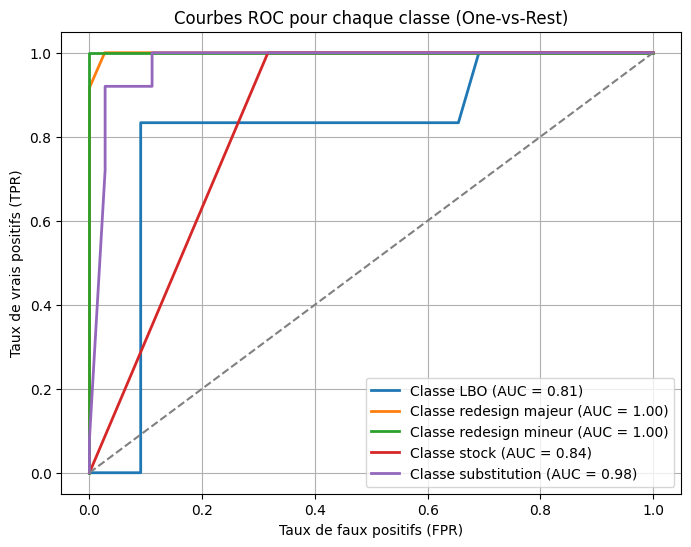

AUC Macro : 0.93, AUC Micro : 0.97


In [211]:
# Récupérer les classes uniques
classes = np.unique(df_test.label)
n_classes = len(classes)

# Binariser les labels (nécessaire pour calculer la courbe ROC)
y_test_binarized = label_binarize(df_test.label, classes=classes)

# Exécution de la fonction
y_pred_proba = proba_moyenne(df_test, foret, nb_elem_)

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Classe {classes[i]} (AUC = {auc_score:.2f})')

# Ajouter la ligne de référence (aléatoire)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Mise en forme du graphe
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbes ROC pour chaque classe (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

auc_macro = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")
auc_micro = roc_auc_score(y_test_binarized, y_pred_proba, average="micro")
print(f"AUC Macro : {auc_macro:.2f}, AUC Micro : {auc_micro:.2f}")



In [212]:
classes = np.unique(df_test.label)
classes

array(['LBO', 'redesign majeur', 'redesign mineur', 'stock',
       'substitution'], dtype=object)

# Grid Search 

In [213]:
import numpy as np
from itertools import product

def accuracy_metric(y_test, y_predicted):
	correct = 0
	for i in range(len(y_test)):
		if y_test[i] == y_predicted[i]:
			correct += 1
	return correct / float(len(y_test)) * 100.0


In [216]:

def grid_search(df_train, df_test, param_grid):
    best_score = -np.inf
    best_params = None
    X_train = df_train.drop("label", axis=1)
    y_train = df_train.label
    X_test = df_test.drop("label", axis=1)
    y_test = df_test.label

    for params in product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        foret = random_forest_algorithm(df_train, **param_dict)
        predictions = random_forest_predictions(X_test, foret)
        score = accuracy_metric(y_test, predictions)
        print(f"Testé: {param_dict} -> Score: {score:.2f}%")
        
        if score > best_score:
            best_score = score
            best_params = param_dict
    
    return best_params, best_score


In [217]:

# Définition des hyperparamètres à tester
param_grid = {
    "n_trees": [50, 100, 200],
    "n_bootstrap": [500, 800, 1000],
    "n_features": [None, 5, 10],
    "dt_max_depth": [50, 100, 150]
}

# Exécution de la recherche par grille
best_params, best_score = grid_search(df_train, df_test, param_grid)
print("Meilleurs paramètres:", best_params)
print(f"Meilleur score: {best_score:.2f}%")

Testé: {'n_trees': 50, 'n_bootstrap': 500, 'n_features': None, 'dt_max_depth': 50} -> Score: 96.72%
Testé: {'n_trees': 50, 'n_bootstrap': 500, 'n_features': None, 'dt_max_depth': 100} -> Score: 96.72%
Testé: {'n_trees': 50, 'n_bootstrap': 500, 'n_features': None, 'dt_max_depth': 150} -> Score: 96.72%
Testé: {'n_trees': 50, 'n_bootstrap': 500, 'n_features': 5, 'dt_max_depth': 50} -> Score: 95.08%
Testé: {'n_trees': 50, 'n_bootstrap': 500, 'n_features': 5, 'dt_max_depth': 100} -> Score: 91.80%
Testé: {'n_trees': 50, 'n_bootstrap': 500, 'n_features': 5, 'dt_max_depth': 150} -> Score: 91.80%
Testé: {'n_trees': 50, 'n_bootstrap': 500, 'n_features': 10, 'dt_max_depth': 50} -> Score: 98.36%
Testé: {'n_trees': 50, 'n_bootstrap': 500, 'n_features': 10, 'dt_max_depth': 100} -> Score: 98.36%
Testé: {'n_trees': 50, 'n_bootstrap': 500, 'n_features': 10, 'dt_max_depth': 150} -> Score: 98.36%
Testé: {'n_trees': 50, 'n_bootstrap': 800, 'n_features': None, 'dt_max_depth': 50} -> Score: 96.72%
Testé: {'